# Quantum Machine Learning Iris Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install qiskit pylatexenc qiskit_machine_learning qiskit-machine-learning

  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 72.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.4/37.4 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [3]:
from sklearn.datasets import load_iris

iris_data = load_iris()

In [4]:
print(iris_data.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [5]:
features = iris_data.data
labels = iris_data.target

In [6]:
from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler().fit_transform(features)

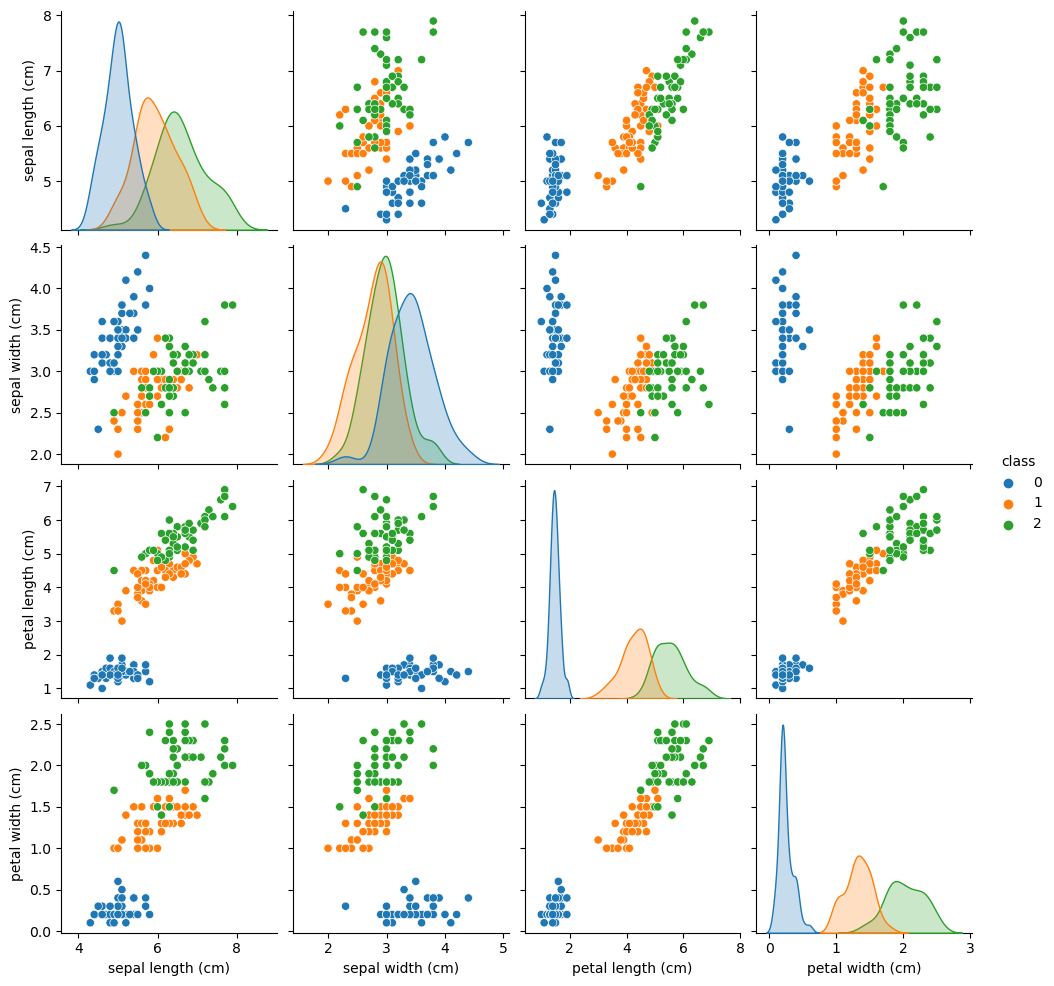

In [7]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df["class"] = pd.Series(iris_data.target)

sns.pairplot(df, hue="class", palette="tab10")

# Classic Machine Learning

In [8]:
from sklearn.model_selection import train_test_split
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

In [9]:
from sklearn.svm import SVC

svc = SVC()
_ = svc.fit(train_features, train_labels)  # suppress printing the return value

In [10]:
train_score_c4 = svc.score(train_features, train_labels)
test_score_c4 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 0.99
Classical SVC on the test dataset:     0.97


# Quantum Machine Learning

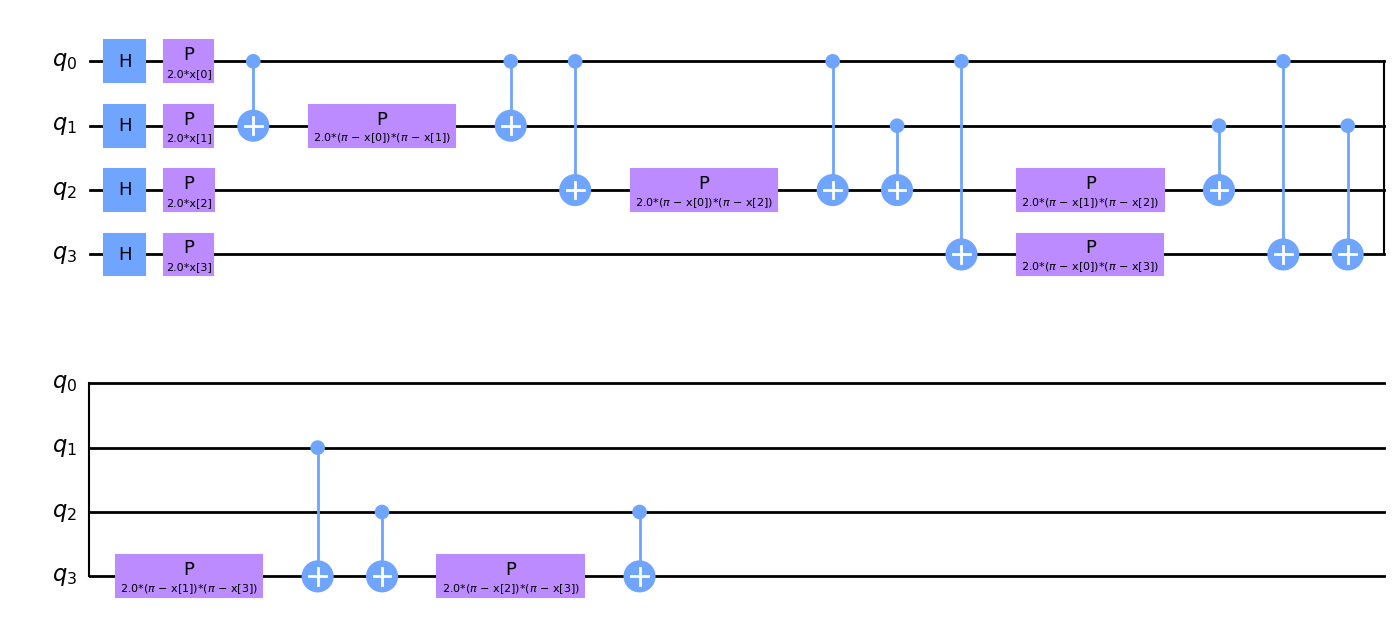

In [11]:
from qiskit.circuit.library import PauliFeatureMap

num_features = features.shape[1]

feature_map = PauliFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", fold=20)

In [12]:
from qiskit.primitives import Sampler

sampler = Sampler()

In [13]:
from qiskit import Aer
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

import time
from qiskit_machine_learning.algorithms.classifiers import QSVC

fidelity = ComputeUncompute(sampler=sampler)
kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

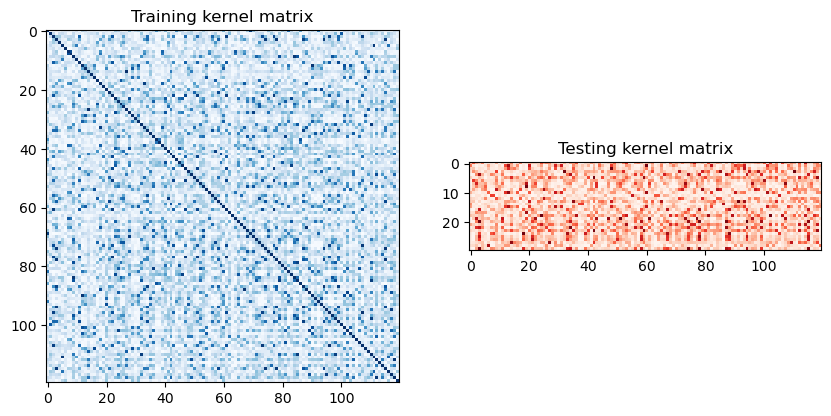

In [14]:
matrix_train = kernel.evaluate(x_vec=train_features)
matrix_test = kernel.evaluate(x_vec=test_features, y_vec=train_features)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(
    np.asmatrix(matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Testing kernel matrix")
plt.show()

In [15]:
# Initialize QSVC algorithm
qsvc = QSVC(quantum_kernel=kernel)

# clear objective value history
objective_func_vals = []

start = time.time()
qsvc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

Training time: 59 seconds


In [16]:
train_score_q4 = qsvc.score(train_features, train_labels)
test_score_q4 = qsvc.score(test_features, test_labels)

print(f"Quantum QSVC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum QSVC on the test dataset:     {test_score_q4:.2f}")

Quantum QSVC on the training dataset: 0.99
Quantum QSVC on the test dataset:     0.97


# Reducing the Number of Features With Principal Component Analysis (PCA)

<AxesSubplot:>

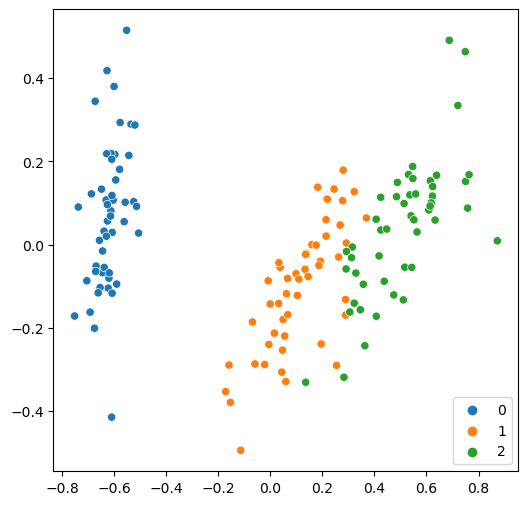

In [17]:
from sklearn.decomposition import PCA

features = PCA(n_components=2).fit_transform(features)

plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=labels, palette="tab10")

# Classic Machine Learning

In [18]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

svc.fit(train_features, train_labels)

train_score_c2 = svc.score(train_features, train_labels)
test_score_c2 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c2:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c2:.2f}")

Classical SVC on the training dataset: 0.97
Classical SVC on the test dataset:     0.90


# Quantum Machine Learning

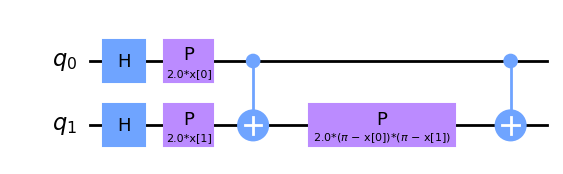

In [19]:
num_features = features.shape[1]

feature_map = PauliFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", fold=20)

In [20]:
from qiskit.primitives import Sampler

sampler = Sampler()

In [21]:
from qiskit import Aer
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

import time
from qiskit_machine_learning.algorithms.classifiers import QSVC

fidelity = ComputeUncompute(sampler=sampler)
kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

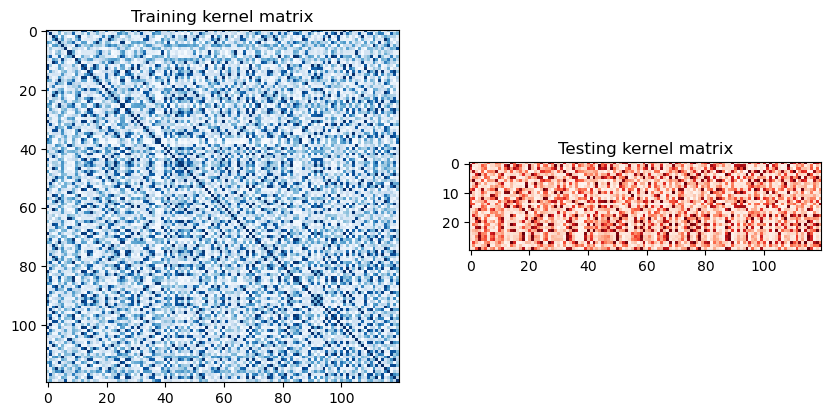

In [22]:
matrix_train = kernel.evaluate(x_vec=train_features)
matrix_test = kernel.evaluate(x_vec=test_features, y_vec=train_features)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(
    np.asmatrix(matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Testing kernel matrix")
plt.show()

In [23]:
# Initialize QSVC algorithm
qsvc = QSVC(quantum_kernel=kernel)

# clear objective value history
objective_func_vals = []

start = time.time()
qsvc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

Training time: 20 seconds


In [24]:
train_score_q2 = qsvc.score(train_features, train_labels)
test_score_q2 = qsvc.score(test_features, test_labels)

print(f"Quantum QSVC the training dataset: {train_score_q2:.2f}")
print(f"Quantum QSVC the test dataset:     {test_score_q2:.2f}")

Quantum QSVC the training dataset: 0.93
Quantum QSVC the test dataset:     0.87


In [25]:
print(f"Model                           | Train Score | Test Score")
print(f"SVC, 4 features                 | {train_score_c4:11.2f} | {test_score_c4:10.2f}")
print(f"QSVC, 4 features                | {train_score_q4:11.2f} | {test_score_q4:10.2f}")
print(f"----------------------------------------------------------")
print(f"SVC, 2 features                 | {train_score_c2:11.2f} | {test_score_c2:10.2f}")
print(f"QSVC, 2 features                | {train_score_q2:11.2f} | {test_score_q2:10.2f}")

Model                           | Train Score | Test Score
SVC, 4 features                 |        0.99 |       0.97
QSVC, 4 features                |        0.99 |       0.97
----------------------------------------------------------
SVC, 2 features                 |        0.97 |       0.90
QSVC, 2 features                |        0.93 |       0.87
